In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    RioCallback,
    recursive_scan,
    Para_init,
    write_excel_xlsx,
    Run_P3_model,
    Plot_Last_Single_Step,
    GetSol_dict,
    Plot_Loc_Var_2,
    Plot_Fig_1,
    Plot_Loc_Var_sol_6,
)

from pybamm import tanh,exp,sqrt
def electrolyte_conductivity_Valoen2005Constant(c_e,c_EC, T):# Mark Ruihe change
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    # mS/cm to S/m
    return sigma
def electrolyte_conductivity_Valoen2005Constant_EC_Haya(c_e,c_EC, T):
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    a=1.092; b=-6.497e-6; c=-0.7877; d=-0.0004808
    ratio= (
        a*exp(b*c_EC)+c*exp(d*c_EC) )
    return sigma*ratio
def electrolyte_conductivity_Valoen2005Constant_ECtanh500_1(c_e,c_EC, T):# Mark Ruihe change
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    coff = 1
    ratio = ( (1-coff)+ coff/2 + coff/2 *  tanh((c_EC-4500*0.5)/500))
    return sigma*ratio

In [3]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[8,],
   "SaveAsList":[  [4,2,1,1,1,1],  ],
   "Ageing temperature":[25,],
   #"Particle mesh points":[120,],
   #"Exponential mesh stretch":[2.3,],
   "Para_Set":[ "Li2023_ECdrag",],
    "Model option":[
        {
            "calculate discharge energy":"true",
            "SEI":"solvent-diffusion limited",             
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",   
            "electrolyte conductivity": "sol full"  ,
            "solvent diffusion": "double spatial consume w refill"   },
    ],
   # solvent diffusion parameters:
   "EC transference number zero":[0.85,],
   "Cation transference number":[0.3,],
   "EC Lithium ion cross diffusivity [m2.s-1]":[3e-11,],
   "EC diffusivity in electrolyte [m2.s-1]":[5e-10],

   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   #"Negative electrode diffusivity [m2.s-1]":[2e-13,],
   #"Positive electrode diffusivity [m2.s-1]":[1e-13,],
   # if want a function, add 'Func', 
   #    if want a constant, delete Func
   # note!!!: Constant will overwrite Func
   "Func Electrolyte conductivity [S.m-1]":[
        "electrolyte_conductivity_Valoen2005Constant",
        ],
    "Func Electrolyte diffusivity [m2.s-1]":[
        "electrolyte_diffusivity_Valoen2005Constant",],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   "Ratio of lithium moles to SEI moles":[2,],
   "Inner SEI reaction proportion":[0.5,],
   "Initial inner SEI thickness [m]":[2.5e-9,],
   "Initial outer SEI thickness [m]":[2.5e-9,],
   # solvent-diffusion limited
   'Outer SEI solvent diffusivity [m2.s-1]':[1.7e-22,],
   'Bulk solvent concentration [mol.m-3]':[4541.0,],
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-20,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity in SEI [m2.s-1]':[1e-21,],
   'SEI kinetic rate constant [m.s-1]':[1e-12,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 1


In [4]:
print(len(Para_dict_list))

1


In [5]:
keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Negative electrode porosity",
    "CCend Positive electrode potential [V]",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend c(EC) over c(Li+)",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",

    "CDend Negative electrode porosity",
    "CDend Positive electrode potential [V]",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend c(EC) over c(Li+)",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",

]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CC Time [h]",
    "CV Time [h]",
    "CD Terminal voltage [V]",
    "CC Terminal voltage [V]",
    "CV Terminal voltage [V]",
]
keys_cyc_AGE = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDsta Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CCsta Loss of capacity to SEI [A.h]",
    "CCend Loss of capacity to SEI [A.h]",
    "CVsta Loss of capacity to SEI [A.h]",
    "CVend Loss of capacity to SEI [A.h]",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Loss of active material in positive electrode [%]",
    "CDend Loss of active material in negative electrode [%]",
    "CDend Total EC in electrolyte [mol]",
    "CDend Total EC in electrolyte and SEI [mol]",
    "CDend Total lithium in electrolyte [mol]",
    "CDend Total lithium in particles [mol]",

]
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];

Successfully create a excel file
Start Now! Scan 1.
try to run 4 cycles
Succeed! Now it is the 4th cycles
try to run 4 cycles
Succeed! Now it is the 8th cycles
No single step
Seems no empty solution
Seems no empty solution


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Successfully create a excel file
Scan No. 1 succeed! Saving succeed as well!


' if __name__ == "__main__":\n    pool = multiprocessing.Pool(1)\n    processes = [pool.apply_async(\n        Run_P3_model, \n        args=(\n            index_i, Para_dict_i,   Path_pack , \n            keys_all_AGE,   Exp_AGE_List, exp_index_pack \n         )   ) \n         for Para_dict_i,index_i in zip(Para_dict_list,Index)]\n    result = [p.get() for p in processes] \n\n    '

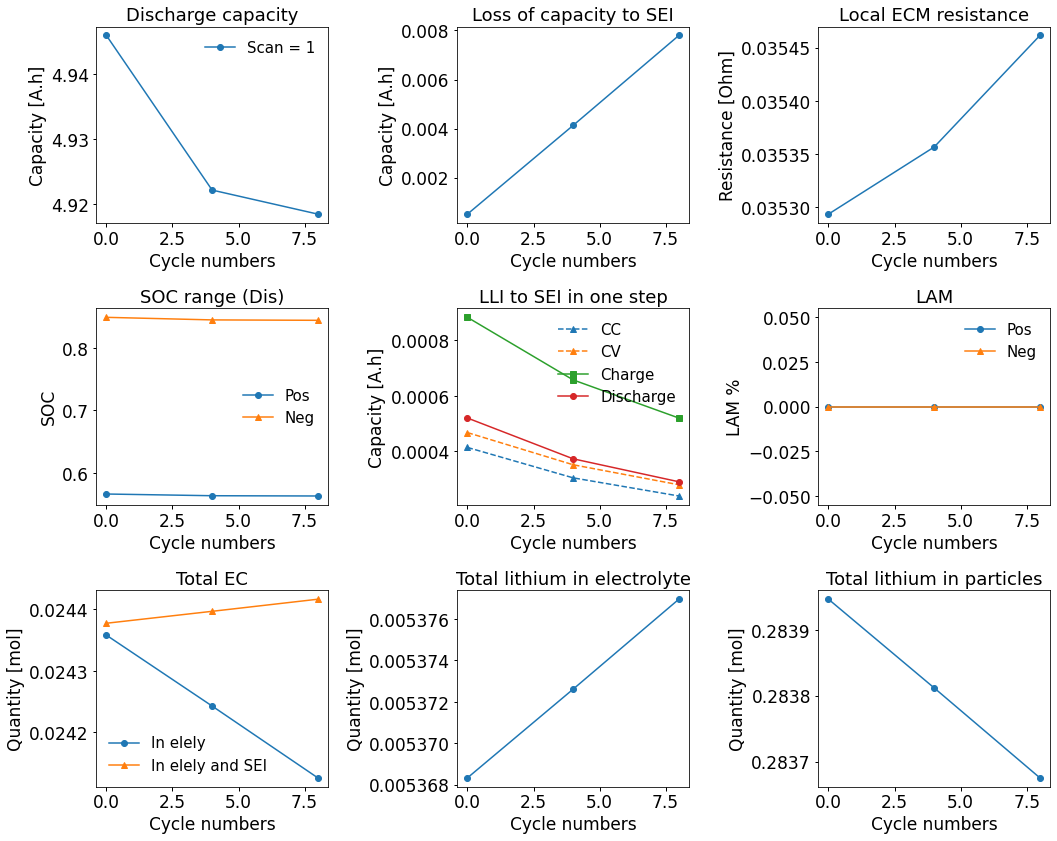

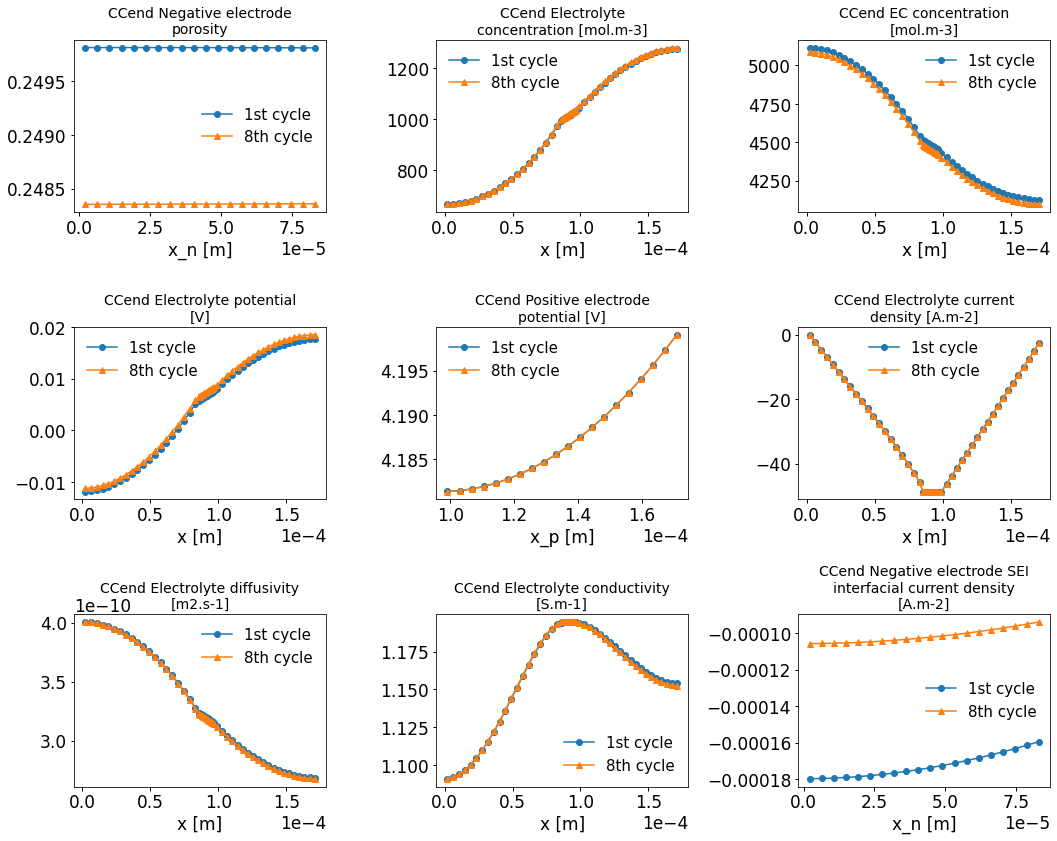

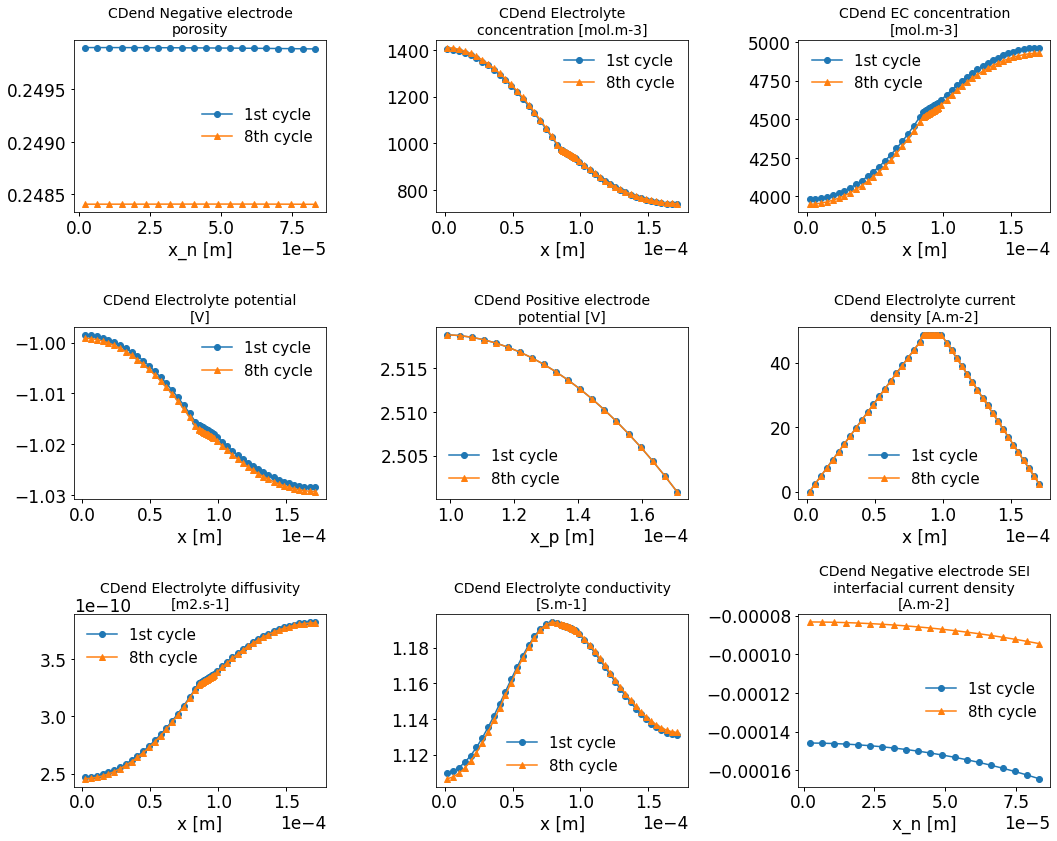

In [6]:
# define experiments and scan!
V_max = 4.2;        V_min = 2.5; 
exp_AGE = [
   (f"Discharge at 1 C until {V_min} V", 
   f"Charge at 1 C until {V_max} V",  # (5 minute period)
   f"Hold at {V_max} V until C/20"),  ]# (5 minute period)
exp_AGE_2 = [
   (f"Discharge at 1 C until {V_min} V (5 seconds period)", 
   f"Charge at 1 C until {V_max} V (5 seconds period)", 
   f"Hold at {V_max} V until C/20 (5 seconds period)"),]
# step index for ageing
exp_AGE_CD = [ (
   f"Discharge at 1 C until {V_min} V (1 seconds period)",   ) ]
exp_AGE_CC = [ (
   f"Charge at 1 C until {V_max} V (1 seconds period)" ) ]
exp_AGE_CV = [ (
   f"Hold at {V_max} V until C/20 (1 seconds period)" ) ]
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

Exp_AGE_List     = [
    exp_AGE,exp_AGE,exp_AGE_2,
    exp_AGE_CD,exp_AGE_CC,exp_AGE_CV];
cycle_no = -1; 
exp_index_pack = [
   cycle_no,step_AGE_CD,
   step_AGE_CC,step_AGE_CV,];
# Path and save to excel
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R11/'; 
Target  = 'test/' # wip\Rio_Code\P3R10\.ipynb
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'test.xlsx';sheet_name_xlsx = 'Results';
Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];
# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.extend([ "exp_AGE_text", 
   "Cap Loss","LLI to SEI",
   "LAM to Neg","LAM to Pos",
   "Error"])
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, [head_list])

###########################################        
#                Scan                     #
###########################################  
Index = np.arange(1,len(Para_dict_list)+1)  
for Para_dict_i,index_i in zip(Para_dict_list,Index):
   Sol_all_i,j,midc_merge = Run_P3_model(
      index_i, Para_dict_i,   Path_pack , 
      keys_all_AGE,   Exp_AGE_List, exp_index_pack 
   )  
""" if __name__ == "__main__":
    pool = multiprocessing.Pool(1)
    processes = [pool.apply_async(
        Run_P3_model, 
        args=(
            index_i, Para_dict_i,   Path_pack , 
            keys_all_AGE,   Exp_AGE_List, exp_index_pack 
         )   ) 
         for Para_dict_i,index_i in zip(Para_dict_list,Index)]
    result = [p.get() for p in processes] 

    """

In [7]:
""" print(
    #Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries  
)
print(
    #Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries
) """
print(
    #Sol_all_i[0].cycles[0].steps[0]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[0]["X-averaged SEI interfacial current density [A.m-2]"].entries  
)
print(
    #Sol_all_i[0].cycles[0].steps[1]["Loss of capacity to SEI [A.h]"].entries[-1] - 
    Sol_all_i[0].cycles[0].steps[1]["X-averaged SEI interfacial current density [A.m-2]"].entries
)

[-0.00017526 -0.00016095 -0.00016072 -0.00016061 -0.00016048 -0.00016033
 -0.00016018 -0.00016003 -0.00015988 -0.00015972 -0.00015957 -0.00015942
 -0.00015926 -0.0001591  -0.00015893 -0.00015872 -0.00015847 -0.00015819
 -0.00015791 -0.00015771 -0.00015763 -0.00015762 -0.00015759 -0.00015752
 -0.00015742 -0.00015729 -0.00015715 -0.000157   -0.00015685 -0.0001567
 -0.00015654 -0.00015638 -0.00015622 -0.00015604 -0.00015586 -0.00015566
 -0.00015545 -0.00015523 -0.000155   -0.00015479 -0.0001546  -0.00015444
 -0.00015432 -0.00015423 -0.00015416 -0.00015409 -0.00015401 -0.00015391
 -0.00015378 -0.00015359 -0.00015336 -0.00015311 -0.00015294 -0.00015288
 -0.00015284 -0.00015278 -0.00015267 -0.00015254 -0.00015242 -0.00015231
 -0.00015227]
[-0.00015227 -0.00017957 -0.00017954 -0.00017942 -0.00017926 -0.00017903
 -0.00017874 -0.00017845 -0.00017819 -0.00017798 -0.00017784 -0.00017774
 -0.00017765 -0.00017756 -0.00017743 -0.00017725 -0.00017704 -0.0001768
 -0.00017655 -0.0001763  -0.00017605 -0

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\pybamm\util.py", line 70, in __getitem__
    return super().__getitem__(key)
KeyError: 'eta_SEI'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\GitPyBaMM\LRH_409\LRH_409\envSolCon\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rl1120\AppData\Local\Temp\ipykernel_21948\3731132339.py", line 1, in <cell line: 1>
    Plot_Loc_Var_sol(
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\wip\Rio_Code\Fun_P3\Fun_P3.py", line 289, in Plot_Loc_Var_sol
    LinesNmum = len(sol.cycles[cycle].steps[step][key].entries[0,:] )
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\pybamm\solvers\solution.py", line 537, in __getitem__
    self.update(key)
  File "d:\gitpybamm\lrh_409\lrh_409\envsolcon\pybamm-gem\pybamm\solvers\solution.

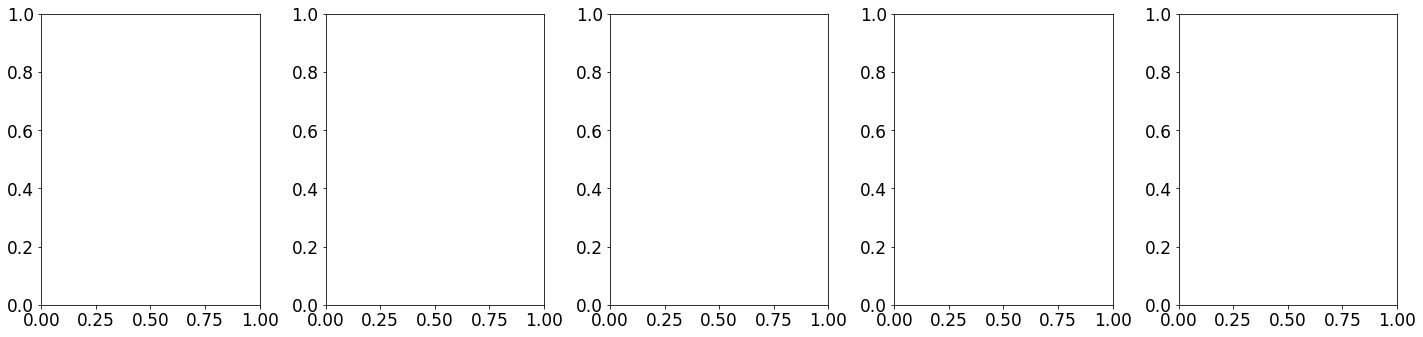

In [8]:
Plot_Loc_Var_sol(
    Sol_all_i[0],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "eta_SEI",
        "Negative EC concentration",
        "EC surface concentration", 
        "C_sei_exp",            
        "Negative electrode SEI interfacial current density [A.m-2]",
        ],
    0,0,'cool',17)
Plot_Loc_Var_sol(
    Sol_all_i[0],
    ["x_n [m]","x_n [m]","x_n [m]","x_n [m]","x_n [m]"], 
    [
        "eta_SEI",
        "Negative EC concentration",
        "EC surface concentration",     
        "C_sei_exp",          
        "Negative electrode SEI interfacial current density [A.m-2]",
        ],
    0,1,'cool',17)

In [9]:
Sol_all_i[0].cycles[0].steps[0]
label = ["Discharge","Charge"]
output_variables3 = [
    "EC concentration",
    "EC source term (SEI)",
    "Minus div EC flux",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
    #"Li+ source term refill",
]
quick_plot = pybamm.QuickPlot(
    [
        Sol_all_i[0].cycles[0].steps[0],
        Sol_all_i[0].cycles[0].steps[1],
        ], 
    output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=2,
    figsize = (12,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=1.6901137084632125, step=0.01690113708463212…

In [10]:
# Write all seperate excel files into a big file:
for i in Index:
    old_book = str(i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    #try:   # use try just in case some cases fail
    data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
    data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

    table_old = data_old.get_sheet_by_name(str(i))
    nrows_old = table_old.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数

    tar_sheet_name_xlsx = 'Results';
    table_tar = data_tar.get_sheet_by_name(tar_sheet_name_xlsx)
    nrows_tar = table_tar.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数
    list_old = [];
    #print(nrows_old,nrows_tar)
    for i in range(1,nrows_old+1):
        for j in range(1,ncolumns_old+1):
            list_old.append(table_old.cell(row=i,column=j).value)

    list_old = [list_old,]
    for i in range(1, len(list_old)+1):
            for j in range(1, len(list_old[i-1])+1):
                #print(i,j,list_old[i-1][j-1]    )
                table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
    data_tar.save(BasicPath + Target + book_name_xlsx) 
    data_tar.close()
    """ except:
        print("Something goes wrong!")
    else:
        pass """

